In [0]:
import os
import glob
import shutil
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as pltImg
import imgaug.augmenters as iaa
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

In [0]:
# Deep learning and ML libraries:
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, GlobalMaxPooling2D, Input
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
%matplotlib inline
color = sns.color_palette()

Using TensorFlow backend.


I've used Google Colab's TPU to run this code since it would have taken me more than 100 hours of training time on my laptop. Therefore you might find some Google Colab specific code which you can simply ignore

In [0]:
#mount google drive on my Google Colab notebook
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Initialzing variables for reproducibility
import tensorflow as tf

# Set seed for hash based ops in python
os.environ["PYTHONHASHSEED"] = "0"

# set numpy random seed
np.random.seed(111)

# disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# set random seed in tf
tf.set_random_seed(111)

# define tf session with above configuraion
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# set session in keras
K.set_session(sess)

# set imgaug seed
aug.seed(111)

The dataset is divided into 3 parts :
1. Train set
2. Test set
3. Validation set

First we will perform analysis on the training set
There's 2 sub directories in each of the set :
* NORMAL - samples with no pneumonia
* PNEUMONIA - samples with pneumonia

In [0]:
normal_dir = Path("/content/gdrive/My Drive/Colab Notebooks/dataset/train/NORMAL")
pneu_dir = Path("/content/gdrive/My Drive/Colab Notebooks/dataset/train/PNEUMONIA")

# list of all images
normal_cases = normal_dir.glob("*.jpeg")
pneu_cases = pneu_dir.glob("*.jpeg")

# list for (img_path, label) format:
train_data = []

# 0 = no pneumonia, 1 = pneumonia
for img in normal_cases:
    train_data.append((img,0))
    
for img in pneu_cases:
    train_data.append((img,1))
    
# creating pandas datafram
train_data = pd.DataFrame(train_data, columns=["image", "label"], index=None)

# shuffling the data
train_data = train_data.sample(frac=1).reset_index(drop=True)

# data sample
train_data.tail()

,image,label
5211,/content/gdrive/My Drive/Colab Notebooks/datas...,0
5212,/content/gdrive/My Drive/Colab Notebooks/datas...,1
5213,/content/gdrive/My Drive/Colab Notebooks/datas...,1
5214,/content/gdrive/My Drive/Colab Notebooks/datas...,1
5215,/content/gdrive/My Drive/Colab Notebooks/datas...,1


Total Number of Cases :
1    3875
0    1341
Name: label, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


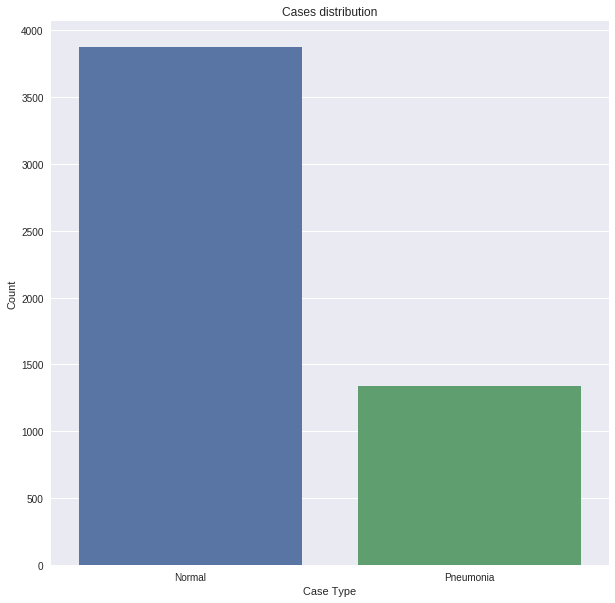

In [0]:
# some EDA

cases_count = train_data["label"].value_counts()
print("Total Number of Cases :")
print(cases_count)

plt.figure(figsize=(10,10))
sns.barplot(x=cases_count, y=cases_count.values)
plt.title("Cases distribution")
plt.xlabel("Case Type")
plt.ylabel("Count")
plt.xticks(range(len(cases_count.index)), ['Normal', 'Pneumonia'])
plt.show()

As we can see the data is highly imbalanced. There are almost thrice the amount of normal cases than pneumonia cases.

In [0]:
# Get the path to the sub-directories
normal_cases_dir = Path("/content/gdrive/My Drive/Colab Notebooks/dataset/val/NORMAL")
pneumonia_cases_dir = Path("/content/gdrive/My Drive/Colab Notebooks/dataset/val/PNEUMONIA")

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)


Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 2)


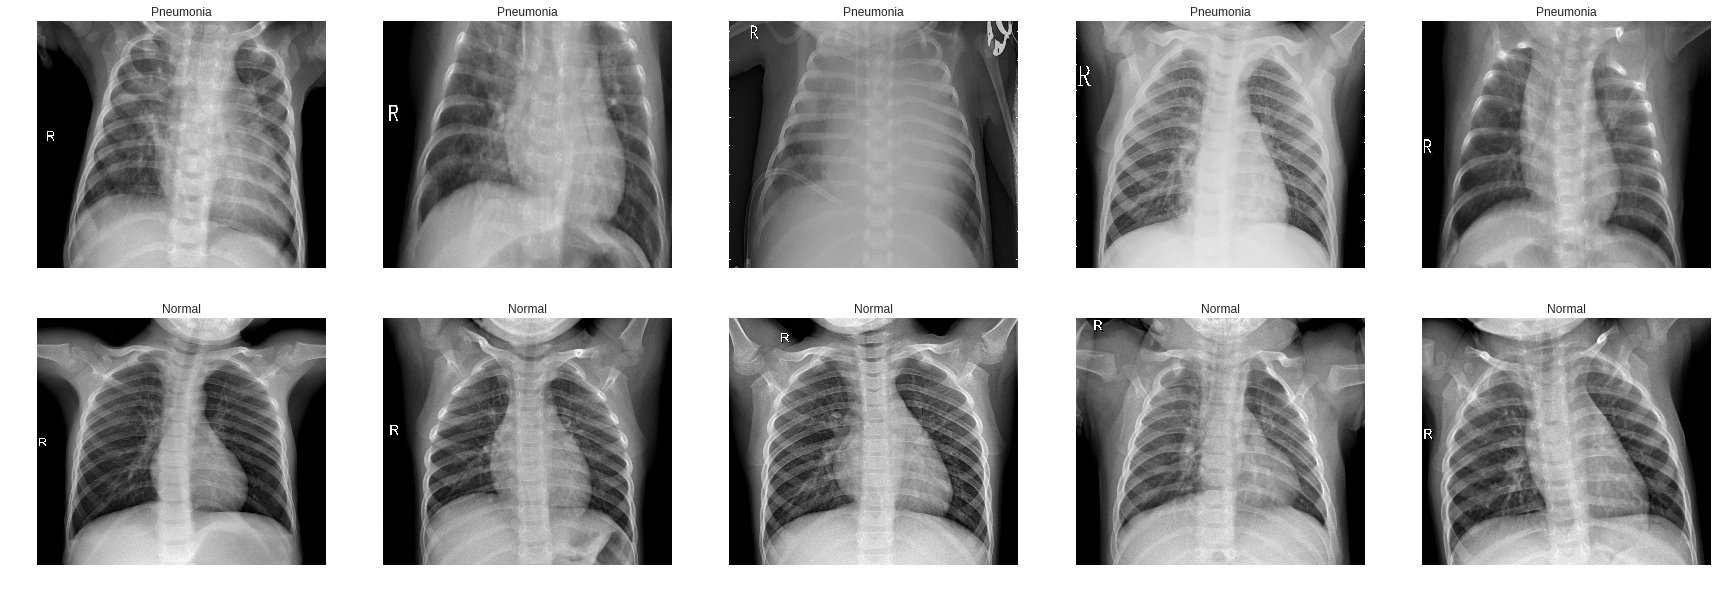

In [0]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

# Augmentation

Since our data is highly imbalanced data augmentation can help us a lot. We can generate differnt types of the imbalanced class, in our case x-rays of pneumonia

In [0]:
# Augmentation Sequence:

seq = iaa.OneOf([
        iaa.Fliplr(), #horizontal flips
        iaa.Affine(rotate=20), #rotation by 20 degrees
        iaa.Multiply((1.2, 1.5)) #random brightness
     ])

# Traning data generator

In [0]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

# Model :

In [0]:
def build_model():
    #input_img = Input(shape=(224,224,3), name='ImageInput')
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=(224,224,3)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1'))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), name='pool1'))
    
    model.add(tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1'))
    model.add(tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), name='pool2'))
    
    model.add(tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1'))
    model.add(tf.keras.layers.BatchNormalization(name='bn1'))
    model.add(tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2'))
    model.add(tf.keras.layers.BatchNormalization(name='bn2'))
    model.add(tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), name='pool3'))
    
    model.add(tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1'))
    model.add(tf.keras.layers.BatchNormalization(name='bn3'))
    model.add(tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2'))
    model.add(tf.keras.layers.BatchNormalization(name='bn4'))
    model.add(tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), name='pool4'))
    
    model.add(tf.keras.layers.Flatten(name='flatten'))
    model.add(tf.keras.layers.Dense(1024, activation='relu', name='fc1'))
    model.add(tf.keras.layers.Dropout(0.7, name='dropout1'))
    model.add(tf.keras.layers.Dense(512, activation='relu', name='fc2'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout2'))
    model.add(tf.keras.layers.Dense(2, activation='softmax', name='fc3'))
    
    #model = Model(inputs=input_img, outputs=x)
    return model

In [0]:
model = build_model()
model.summary()

AttributeError: ignored

## Transfer learning

Here we are not training the entire model based upon transfer learning. Only the first two convolution are trained with Imagenet weights.

In [0]:
import h5py
# Open the VGG16 weight file
f = h5py.File('/content/gdrive/My Drive/Colab Notebooks/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

## Compile the model

In [0]:
batch_size = 16
epochs = 20

train_data_gen = data_gen(data=train_data, batch_size=batch_size)

training_steps = train_data.shape[0]//batch_size

In [0]:
model = build_model()
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.123.122.34:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10362150188205248404)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15840912449927530373)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 7559174122554804485)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12318136325102153257)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1620839783300734857)
INFO:tensorflow:*** Available Device: _Devi

In [0]:
#optimizer = Adam(lr = 0.0001, decay=1e-6)
#early_stopping = EarlyStopping(patience=5)
#chkpt = ModelCheckpoint(filepath="model1", save_best_only=True, save_weights_only=True)
#tpu_model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer)

tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=0.0001,beta1=1e-6),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['accuracy'])

In [0]:


model1 = tpu_model.fit_generator(train_data_gen, epochs=epochs, steps_per_epoch=training_steps, validation_data=(valid_data, valid_labels),
                            class_weight={0:1.0, 1:0.4},
                            verbose=1)

Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(2,), dtype=tf.int32, name='core_id_20'), TensorSpec(shape=(2, 224, 224, 3), dtype=tf.float32, name='batch_normalization_1_input_10'), TensorSpec(shape=(2, 2), dtype=tf.float32, name='fc3_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for batch_normalization_1_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 17.181851625442505 secs
INFO:tensorflow:Setting weights on TPU model.
325/326 [============================>.] - ETA: 1s - loss: 0.3183 - acc: 0.8475INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(2,), dtype=tf.int32, name='core_id_30'), TensorSpec(shape=(2, 224, 224, 3), dtype=tf.float32, name='batch_normalization_1_input_10'), TensorSpec(shape=(2, 2), dtype=tf.float32, name='fc3_target_30')]
INFO:tensorflow:Overriding default placeholder.

In [0]:
model.save("raynet.h5")